# Kit and Membrane Segmentation

In this notebook we go over the main functions, methods, classes and modules that build the kit and membrane segmentation app.

## Packages

We first load some standard Python packages as well as our own custom modules.

In [1]:
import yaml
import os
import numpy as np
import torch
import matplotlib.pyplot as plt
import cv2

from torchvision.transforms import functional as F
from torch.utils.data import DataLoader
from torch.optim import SGD, Adam

# Mount drive and change working directory (only for colab)
from google.colab import drive
drive.mount('/content/drive')
project_folder_path = '/content/drive/MyDrive/CoVision'
os.chdir(project_folder_path)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Parameters

All setting parameters, hyperparameters, etc are stored in a `configuration_segmentation.yaml` file, and they are shared along all files that shape the segmentation app.

In [2]:
# Read the configuration file
# cwd = '.'  # Current working directory (for local)
cwd = os.getcwd()  # Current working directory (for colab)

with open('config_segmentation.yaml', 'r') as f:
    config = yaml.safe_load(f)

# Update dirs to cwd
config['DataSettings']['data_dir'] = os.path.join(cwd, config['DataSettings']['data_dir'])
config['TrainingParameters']['save_path'] = os.path.join(cwd, config['TrainingParameters']['save_path'])
config['DataSettings']['output_dir'] = os.path.join(cwd, config['DataSettings']['output_dir'])

# Split into sub-variables
data_settings = config['DataSettings']
transformation_parameters = config['TransformationParameters']
training_parameters = config['TrainingParameters']

print(data_settings)
print(transformation_parameters)
print(training_parameters)

{'data_dir': '/content/drive/MyDrive/CoVision/data_segmentation', 'output_dir': '/content/drive/MyDrive/CoVision/output', 'split_ratio': 0.8, 'background_id': 0, 'background_color': [255, 0, 0], 'classes': ['kit', 'membrane'], 'class_ids': [1, 2], 'class_colors': [[0, 0, 255], [0, 255, 0]], 'resize_height': 800}
{'rotate_limit': 80, 'rotate_p': 0.8, 'horizontal_flip_p': 0.5, 'blur_limit': 5, 'blur_p': 0.8, 'color_jitter_brightness': 0.1, 'color_jitter_contrast': 0.1, 'color_jitter_saturation': 0.1, 'color_jitter_p': 0.5}
{'save_path': '/content/drive/MyDrive/CoVision/saved_models', 'train_validation_ratio': 0.8, 'num_workers': 0, 'batch_size': 4, 'seed': 42, 'num_epochs': 10, 'num_classes': 3, 'hidden_size': 256, 'learning_rate': '5e-5', 'score_thresholds': [0.85, 0.85], 'mask_thresholds': [0.85, 0.85]}


## LFA Data

We now explore the LFA data in all the formats it takes along the training pipeline. All of them are encoded in a segmentation data folder, whose path is given in the `data_dir` value of the configuration file.

Each test kit has its own set of data files labeled by the corresponding `kit_id`, eg. `btnx`, `abbott`, etc.

### Raw data

The raw (and minimal required) form of data comes divided in the `{kit_id}_images` and `{kit_id}_masks` folders containing, respectively, images (.jpg) and their corresponding human-anotated masks (.png). The latter contains the background in blue, kit in red and membrane in green.

In [3]:
kit_id = 'btnx'

images_folder = os.path.join(data_settings['data_dir'], f'{kit_id}_images')
masks_folder = os.path.join(data_settings['data_dir'], f'{kit_id}_masks')

image_paths = sorted([os.path.join(images_folder, img) for img in os.listdir(images_folder)])
masks_paths = sorted([os.path.join(masks_folder, masks) for masks in os.listdir(masks_folder)])

print(f'Number of images: {len(image_paths)}')
print(f'First image path: {image_paths[0]}')

print(f'Number of masks: {len(masks_paths)}')
print(f'First mask path: {masks_paths[0]}')

Number of images: 83
First image path: /content/drive/MyDrive/CoVision/data_segmentation/btnx_images/5.5_btnxc batch_1_AB279.jpg
Number of masks: 83
First mask path: /content/drive/MyDrive/CoVision/data_segmentation/btnx_masks/5.5_btnxc batch_1_AB279.png


Types (img, mask): <class 'numpy.ndarray'>, <class 'numpy.ndarray'>
Shapes (img, mask): (2540, 1092, 3), (2540, 1092, 3)
Max-Min values (img, mask): (255, 0), (255, 0)


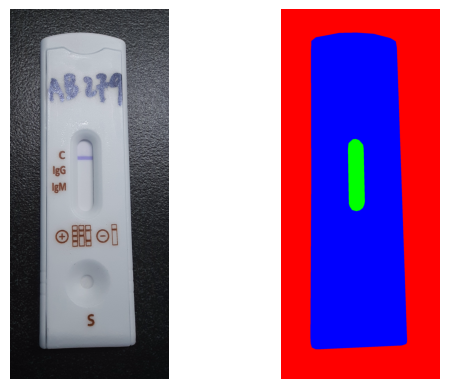

In [4]:
# Read image and mask
image_raw = cv2.imread(image_paths[0])
masks_raw = cv2.imread(masks_paths[0])
print(f'Types (img, mask): {type(image_raw)}, {type(masks_raw)}')
print(f'Shapes (img, mask): {image_raw.shape}, {masks_raw.shape}')
print(f'Max-Min values (img, mask): ({image_raw.max()}, {image_raw.min()}), ({masks_raw.max()}, {masks_raw.min()})')

# Display
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(image_raw)
ax1.axis('off')
ax2.imshow(masks_raw)
ax2.axis('off')
plt.show()

### Train/Test split

The raw data must be split into training and test sets. In order to do so we use the function `split_files_train_test()`, which creates four folders: `{kit_id}_train_images`, `{kit_id}_test_images`, `{kit_id}_train_masks`, and `{kit_id}_test_masks` by splitting the raw data randomly given a fixed split ratio. The latter is defined in the configuration file. If any of the folders already exist, the split is not carried on!

In [5]:
from utils_segmentation.utils_dataset import split_files_train_test

In [6]:
train_images_path = os.path.join(data_settings['data_dir'], f'{kit_id}_train_images')
# Perform split if path do not exist
if not os.path.exists(train_images_path):
    split_files_train_test(kit_id)
else:
    print(f"{train_images_path} already exists!")

/content/drive/MyDrive/CoVision/data_segmentation/btnx_train_images already exists!


In [7]:
# Check train and test lenghts
train_images_path = os.path.join(data_settings['data_dir'], f'{kit_id}_train_images')
test_images_path = os.path.join(data_settings['data_dir'], f'{kit_id}_test_images')
print(f'Length (raw, train, test) sets: {(len(image_paths), len(os.listdir(train_images_path)), len(os.listdir(test_images_path)))}')

Length (raw, train, test) sets: (83, 66, 17)


### Building ground truth from masks

Once train and test folders are created, we can build the target variables (ground truths), as they are required for training the segmentation model, from each human-annotated mask using the function `build_target_from_mask()`. For each RGB mask, this function returns a dictionary containing the class category masks (one-hot-encoding), bounding boxes, and labels, all in numpy array format.

In [8]:
from utils_segmentation.utils_dataset import build_target_from_mask

In [9]:
masks_n, boxes_n, labels_n = build_target_from_mask(masks_raw)

print(f'Masks shapes and unique values: {masks_n.shape}, {np.unique(masks_n)}')
print(f'Bounding boxes: {boxes_n}')
print(f'Labels: {labels_n}')

Masks shapes and unique values: (2, 2540, 1092), [0. 1.]
Bounding boxes: [[ 202.  162.  865. 2335.]
 [ 460.  892.  575. 1387.]]
Labels: [1 2]


### Dataset

After train and test folders are created, we can use the `LFASegmentationDataset` class to create our custom Pytorch's dataset.

In [10]:
from dataset_segmentation import LFASegmentationDataset

In [11]:
dataset_train = LFASegmentationDataset(config=data_settings, kit_id='btnx', dataset='train', transforms=None)
dataset_test = LFASegmentationDataset(config=data_settings, kit_id='btnx', dataset='test', transforms=None)

Loaded 66 image and mask paths!
Loaded 17 image and mask paths!


The dataset elements can be accessed via the custom `__getitem__` method. Each element is a tuple of the form (image, target). The former corresponds to the raw, resized image while target is a dictionary containg the  previously introduced target variables (category masks, bounding boxes, and labels). Both image and target variables are always converted to torch Tensors. If a custom transformation is passed in the `transformation` option during initialization, the output elements are not the raw ones, but the output of those transformations.

In [12]:
image, target = dataset_train[0]
print(f'Image type, shape and max-min values: {type(image)}, {image.shape}, {image.max()}, {image.min()}')
print(target)

Image type, shape and max-min values: <class 'torch.Tensor'>, torch.Size([3, 800, 343]), 1.0, 0.0
{'masks': tensor([[[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]],

        [[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]]], dtype=torch.uint8), 'boxes': tensor([[ 64.,  51., 271., 735.],
        [145., 281., 180., 436.]]), 'labels': tensor([1, 2])}


### DataLoaders

Finally, these dataset are uses to generate the corresponding DataLoaders, which randomly generate batches of (image, target) pairs to use during training and validation. The format in which these batches are retrieved is dictated by the custom `collate_fn` method.

In [13]:
from utils_segmentation.utils import collate_fn

In [14]:
loader_train = DataLoader(dataset=dataset_train,
                          batch_size=training_parameters['batch_size'],
                          shuffle=True,
                          num_workers=training_parameters['num_workers'],
                          collate_fn=collate_fn,
                          pin_memory=True)

loader_test = DataLoader(dataset=dataset_test,
                         batch_size=training_parameters['batch_size'],
                         shuffle=False,
                         num_workers=training_parameters['num_workers'],
                         collate_fn=collate_fn,
                         pin_memory=True)

In [15]:
batch = next(iter(loader_train))
print(f'Length batch: {len(batch[0])}')

images, targets = batch[0], batch[1]
image, target = images[0], targets[0]
print(f'Image type, shape and max-min values: {type(image)}, {image.shape}, {image.max()}, {image.min()}')
print(target)

Length batch: 4
Image type, shape and max-min values: <class 'torch.Tensor'>, torch.Size([3, 800, 600]), 0.9960784316062927, 0.0
{'masks': tensor([[[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]],

        [[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]]], dtype=torch.uint8), 'boxes': tensor([[225., 218., 367., 645.],
        [287., 367., 310., 466.]]), 'labels': tensor([1, 2])}


### Visualization

We can visualize images, their masks and bounding boxes using the `show_image` function

In [16]:
from utils_segmentation.visualization import show_images

In [17]:
show_images(images, targets)

Output hidden; open in https://colab.research.google.com to view.

### Transformations

For data augmentation we will use the `albumentation` package. The nice thing about this package is that it can be used in pairs of (image, mask), so the same transformation is done on both simultaneously.

In [18]:
import albumentations as A

In [19]:
# Read a single pair of image and mask to show the effect of different transformations
kit_id = 'btnx'

images_folder = os.path.join(data_settings['data_dir'], f'{kit_id}_images')
masks_folder = os.path.join(data_settings['data_dir'], f'{kit_id}_masks')

image_paths = sorted([os.path.join(images_folder, img) for img in os.listdir(images_folder)])
masks_paths = sorted([os.path.join(masks_folder, masks) for masks in os.listdir(masks_folder)])

image = cv2.imread(image_paths[0])
mask = cv2.imread(masks_paths[0])

(2540, 1092, 3) (2540, 1092, 3)


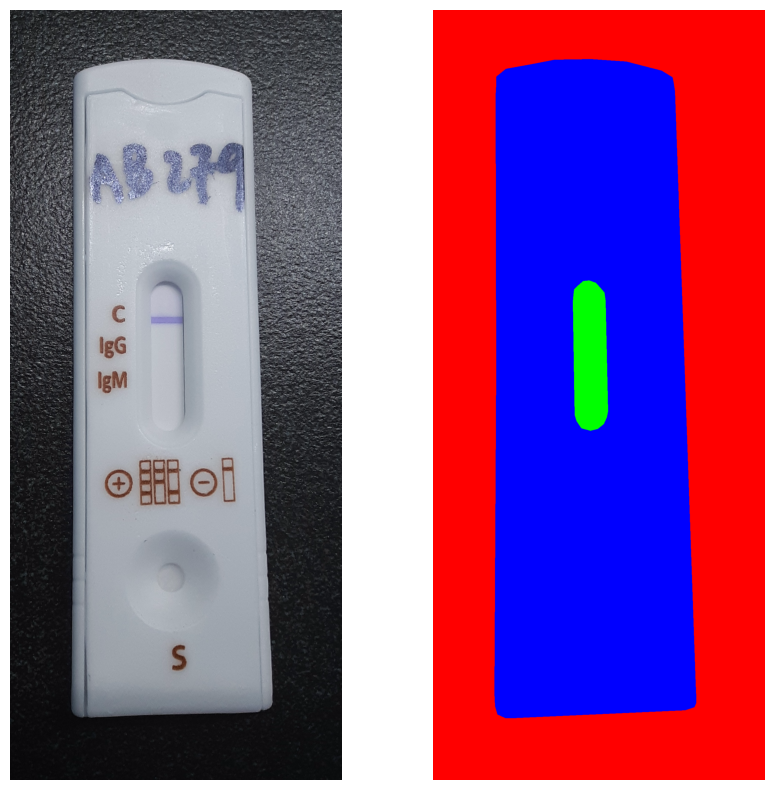

In [20]:
# Original image and mask
print(image.shape, mask.shape)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 10))
ax1.imshow(image)
ax1.axis('off')
ax2.imshow(mask)
ax2.axis('off')
plt.show()

Since displaying large images can be time consuming, we resize them prior to any other data augmentation trasnformation. We do this by using our custom `resize_image` function

In [21]:
from transformations_segmentation import resize_image

In [22]:
image = resize_image(image, data_settings['resize_height'])
mask = resize_image(mask, data_settings['resize_height'])
print(image.shape, mask.shape)

(800, 343, 3) (800, 343, 3)


We now explore the effect of different data augmentation transformations

#### Rotation

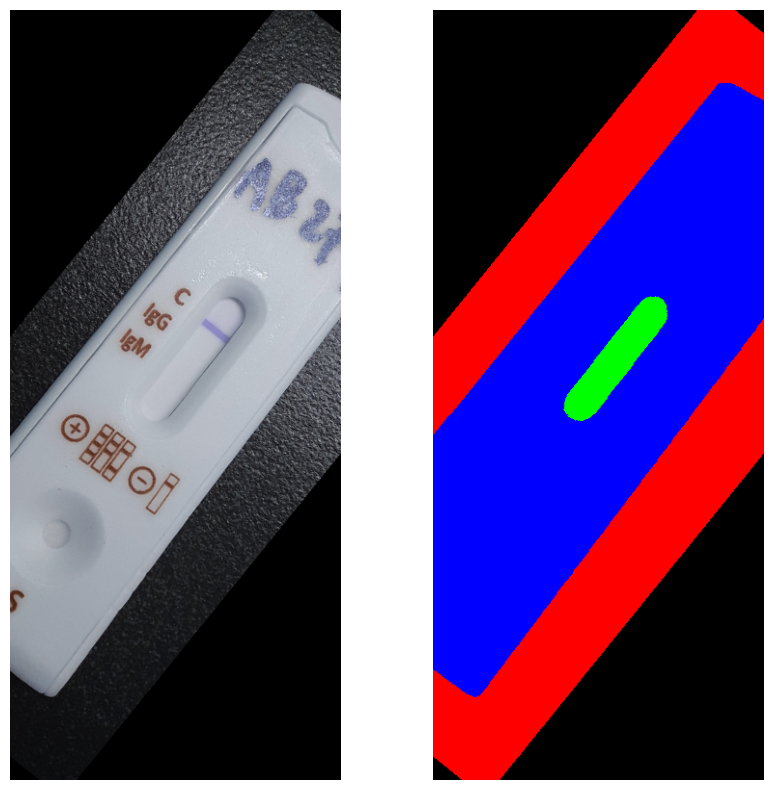

In [23]:
rotate = A.Rotate(limit=transformation_parameters['rotate_limit'], p=1.0, border_mode=cv2.BORDER_CONSTANT)
transformation_dict = rotate(image=image, mask=mask)
image_t, mask_t = transformation_dict['image'], transformation_dict['mask']

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 10))
ax1.imshow(image_t)
ax1.axis('off')
ax2.imshow(mask_t)
ax2.axis('off')
plt.show()

#### Horizontal flip

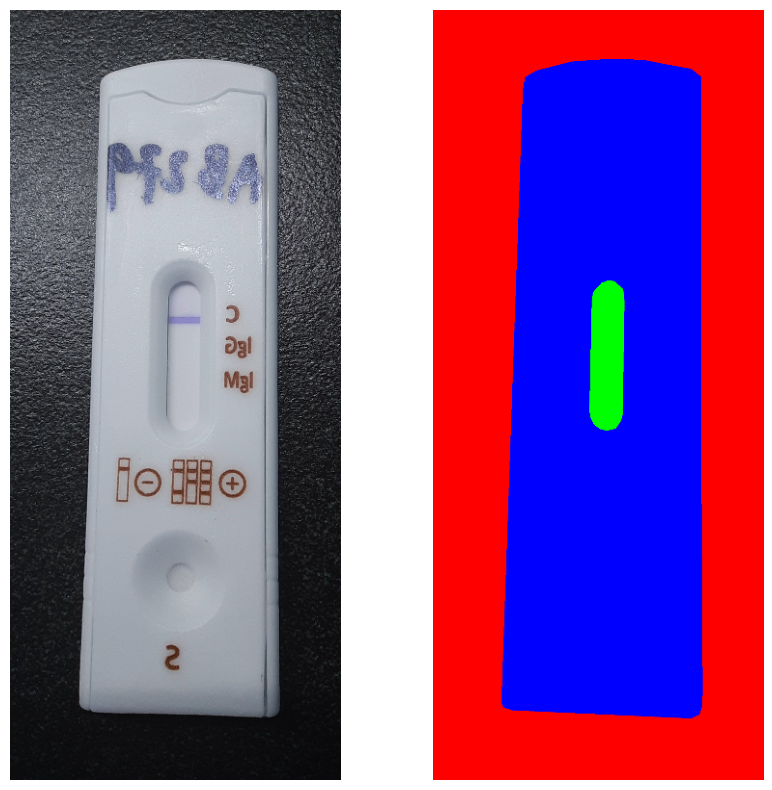

In [24]:
horizontal_flip = A.HorizontalFlip(p=1.0)
transformation_dict = horizontal_flip(image=image, mask=mask)
image_t, mask_t = transformation_dict['image'], transformation_dict['mask']

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 10))
ax1.imshow(image_t)
ax1.axis('off')
ax2.imshow(mask_t)
ax2.axis('off')
plt.show()

#### Blur

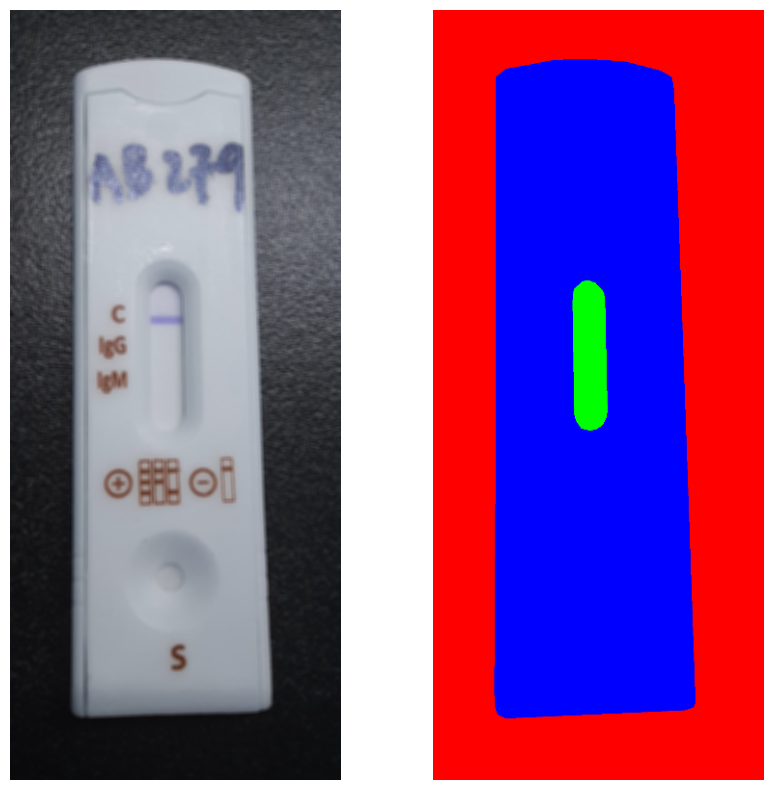

In [25]:
blur = A.Blur(blur_limit=transformation_parameters['blur_limit'], p=1.0)
transformation_dict = blur(image=image, mask=mask)
image_t, mask_t = transformation_dict['image'], transformation_dict['mask']

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 10))
ax1.imshow(image_t)
ax1.axis('off')
ax2.imshow(mask_t)
ax2.axis('off')
plt.show()

#### Color jitter

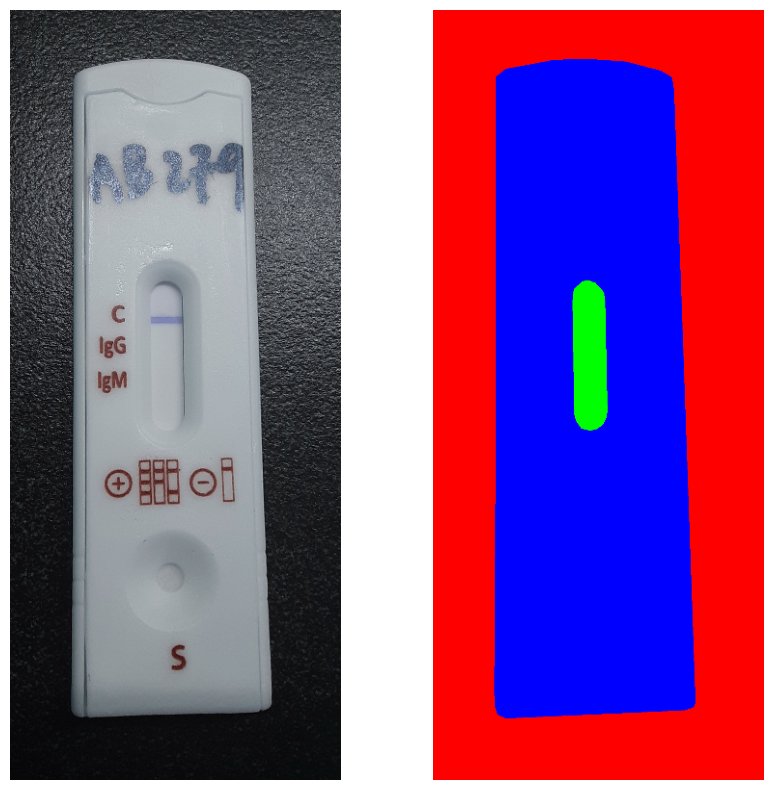

In [26]:
color_jitter = A.ColorJitter(brightness=transformation_parameters['color_jitter_brightness'],
                             contrast=transformation_parameters['color_jitter_contrast'],
                             saturation=transformation_parameters['color_jitter_saturation'],
                             p=1.0)
transformation_dict = color_jitter(image=image, mask=mask)
image_t, mask_t = transformation_dict['image'], transformation_dict['mask']

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 10))
ax1.imshow(image_t)
ax1.axis('off')
ax2.imshow(mask_t)
ax2.axis('off')
plt.show()

#### Altogether

We combined all these transformations in a `TransformationSegmentationTraining` class. The transformation parameters are pre-determined and can be read from the configuration file.

In [27]:
from transformations_segmentation import TransformationSegmentationTraining

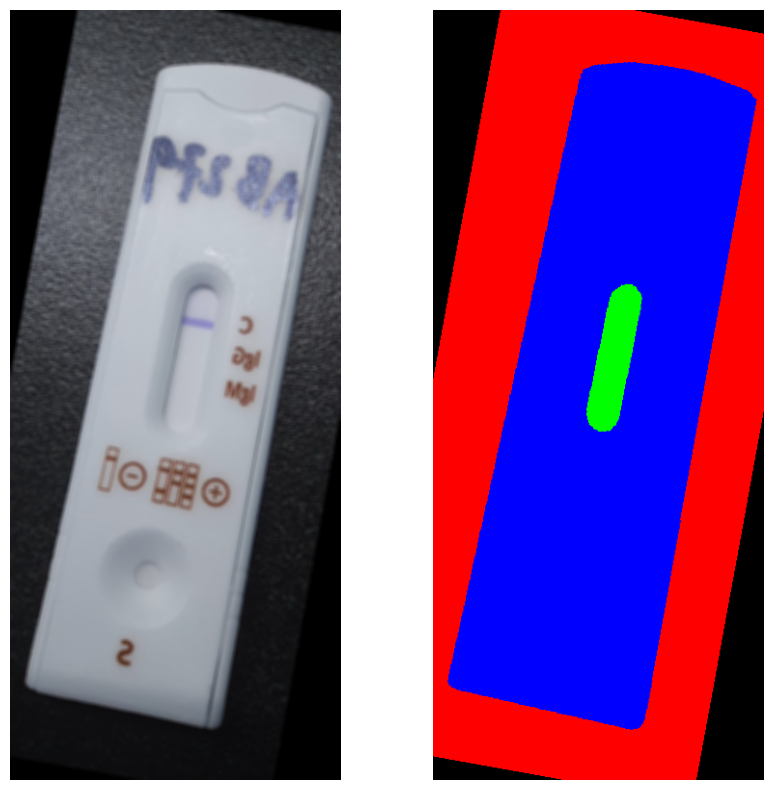

In [28]:
compose_transformation = TransformationSegmentationTraining(transformation_parameters)
image_t, mask_t = compose_transformation(image, mask)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 10))
ax1.imshow(image_t)
ax1.axis('off')
ax2.imshow(mask_t)
ax2.axis('off')
plt.show()

### Final form of dataset + dataloader + transformations

In [29]:
# Create dataset and dataloader
kit_id = 'btnx'

transformation_train = TransformationSegmentationTraining(transformation_parameters)

dataset_train = LFASegmentationDataset(data_settings, kit_id, dataset='train', transforms=transformation_train)

loader_train = DataLoader(dataset=dataset_train,
                          batch_size=training_parameters['batch_size'],
                          shuffle=True,
                          num_workers=training_parameters['num_workers'],
                          collate_fn=collate_fn,
                          pin_memory=True)

# Read batch
batch = next(iter(loader_train))
images, targets = batch[0], batch[1]

# Display batch
show_images(images, targets)

Output hidden; open in https://colab.research.google.com to view.

## Model architecture

For the segmentation task we use the [mask R-CNN](https://arxiv.org/abs/1703.06870) architecture, pre-trained on the COCO dataset, and adapted to our particular segmentation task. The adapted model is obtained through the custom function `get_segmentation_model`.

In [30]:
from model_segmentation import get_segmentation_model

In [31]:
model = get_segmentation_model(num_classes=training_parameters['num_classes'],
                               hidden_size=training_parameters['hidden_size'])

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MaskRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=MaskRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


The model's input and output depend on whether we are in training or evaluation mode.

In training mode, the model requires batches of (image, target) pairs, and it returns a dictionary containing different classification and regression losses, computed from the different parts of the mask R-CNN model (object detection part, mask part, classifier, etc).

In [32]:
dataset_train = LFASegmentationDataset(data_settings, kit_id, dataset='train', transforms=None)
loader_train = DataLoader(dataset=dataset_train, batch_size=1, shuffle=False,
                          num_workers=0, collate_fn=collate_fn, pin_memory=True)

# Read batch
batch = next(iter(loader_train))
images, targets = batch[0], batch[1]

Loaded 66 image and mask paths!


In [33]:
model.train()
loss = model(images, targets)
for k, v in loss.items():
    print(f'{k}: {v}')

loss_classifier: 0.9993736147880554
loss_box_reg: 0.1159430667757988
loss_mask: 3.8781676292419434
loss_objectness: 0.04104892164468765
loss_rpn_box_reg: 0.023094382137060165


In evaluation mode, the model requires only batches of single images as inputs (no targets!), and it returns, for each image in the batch, a dictionary. Such a dictionary contains several predictions (100 top), each with its corresponding mask, bounding box, label and score.

In [34]:
model.eval()
with torch.no_grad():
    prediction_batch = model(images)

# Get single element from batch
prediction = prediction_batch[0]
for k, v in prediction.items():
    print(f'{k}: type: {type(v)}, shape: {v.shape}')

boxes: type: <class 'torch.Tensor'>, shape: torch.Size([100, 4])
labels: type: <class 'torch.Tensor'>, shape: torch.Size([100])
scores: type: <class 'torch.Tensor'>, shape: torch.Size([100])
masks: type: <class 'torch.Tensor'>, shape: torch.Size([100, 1, 800, 343])


In [35]:
for k, v in prediction.items():
    print(f'One {k}: {v[0]}')

One boxes: tensor([160.1163, 157.6965, 186.0012, 207.6624])
One labels: 2
One scores: 0.5603615045547485
One masks: tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]])


## Training App

We now move to the training app, encoded in the `TrainingSegmentation` class.

In [36]:
from training_segmentation import TrainingSegmentation

In [37]:
training_app = TrainingSegmentation(config_file=config,
                                    kit_id='btnx',
                                    transformation_train=None,
                                    transformation_val=None)

Using cuda device
Random seed set as 42
Loading data...
Loaded 52 image and mask paths!
Loaded 14 image and mask paths!


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MaskRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=MaskRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


### Class attributes

Upon initialization, the class builds several attributes. Some related to the variables inside the configuration file, to hyperparameters, data loaders, model design, etc. Some of the most important ones are listed in what follows:

#### Training and validation metrics

In [38]:
training_app.metrics_train

{'loss_classifier': [],
 'loss_box_reg': [],
 'loss_mask': [],
 'loss_objectness': [],
 'loss_rpn_box_reg': [],
 'total_loss': []}

In [39]:
training_app.metrics_val

{'score_kit': [],
 'score_membrane': [],
 'iou_mask_kit': [],
 'iou_mask_membrane': [],
 'iou_box_kit': [],
 'iou_box_membrane': []}

#### Model

In [40]:
training_app.model.__class__

torchvision.models.detection.mask_rcnn.MaskRCNN

#### Training and validation datasets

The training app only uses the training data stored in the folders `{kit_id}_train_images` and `{kit_id}_train_masks`. The set is then split into training and validation sets via the class' method `split_train_val_filenames`. It splits the original set randomly (using the train/val ratio stored in the configuration file) and returns a set of filenames for each set. Those filenames are stored in the attributes `filenames_train`, `filenames_val`. From then, the `init_dataloader` method creates the corresponding datasets and dataloaders, which are stored in `loader_train` and `loader_val`.

It is worth mentioning that the `set_seed` function allows us to reproduce the same split every time!

In [41]:
# Filenames and loaders
filenames_train, filenames_val = training_app.filenames_train, training_app.filenames_val
loader_train, loader_val = training_app.loader_train, training_app.loader_val

print(f'Training set length and first files: {len(filenames_train)}, {filenames_train[:2]}')
print(f'Validation set length and first files: {len(filenames_val)}, {filenames_val[:2]}')

Training set length and first files: 52, ['5.5_btnxc_batch_10_AB226', '5.6_btnxc_batch_20_S578']
Validation set length and first files: 14, ['IMG_5474', '5.5_btnxc_batch_22_AB339']


### Class methods

Apart from the above mentioned attributes, the training app also contains the following methods:

In [42]:
print('main:', training_app.main.__doc__)
print('init_dataloader:', training_app.init_dataloader.__doc__)
print('split_train_val_filenames:', training_app.split_train_val_filenames.__doc__)
print('train:', training_app.train.__doc__)
print('validate:', training_app.validate.__doc__)
print('get_metrics:', training_app.get_metrics.__doc__)
print('save_model:', training_app.save_model.__doc__)
print('load_state:', training_app.load_state.__doc__)

main: 
        Here is where the magic happens. It trains and validates the model for all epochs, store the training and
        validation metrics, display the results and save the best models.
        
init_dataloader: 
        Initialize train and validation dataloaders by splitting the original train dataset
        
split_train_val_filenames: 
        Split filenames into training and validation subsets
        
train: 
        Train model for one epoch and return training total loss
        
validate: 
        Validate the model over the entire validation set, calculate and update performance metrics (IoU)
        
get_metrics: 
        Returns metrics as Pandas DataFrames ready to be plotted
        
save_model: 
        Save model state, parameters, and metrics.
        
load_state: 
        Load model state and metrics
        


### Training the model

In order to train, and validate the model, display and store the performance metrics one runs the `main` method, specifying whether we want to save the model or not. In case we do, the model is saved with a unique identifier corresponding to the exact time the training process started. Such identifier can be accessed via the `stamp` attribute.

All hyperparameters required to train the model, such as learning rate, numer of epochs, batches, workers, etc must be stored in the configuration file.

In [66]:
# Example of training process (run only in presence of a GPU, otherwise it takes too long!)
config['TrainingParameters']['num_epochs'] = 5
config['TrainingParameters']['num_workers'] = 2
config['TrainingParameters']['batch_size'] = 8
config['TrainingParameters']['train_validation_ratio'] = 0.80
config['TrainingParameters']['mask_thresholds'] = [0.7, 0.7]
config['TrainingParameters']['learning_rate'] = 1e-4

transformation_train = TransformationSegmentationTraining(transformation_parameters)

training_app = TrainingSegmentation(config_file=config, kit_id='btnx',
                                    transformation_train=transformation_train,
                                    transformation_val=None)
training_app.main(save_bool=False)

Using cuda device
Random seed set as 42
Loading data...
Loaded 52 image and mask paths!
Loaded 14 image and mask paths!


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 1: lr 0.0001 -> 9.5e-05


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 2: lr 9.5e-05 -> 9.025e-05


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 3: lr 9.025e-05 -> 8.573749999999999e-05


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 4: lr 8.573749999999999e-05 -> 8.145062499999998e-05


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

KeyboardInterrupt: 

A saved model and its metrics history can be loaded via the `load_state` method. The metrics can be accessed in Pandas Dataframe format using the `get_metrics` method. The validation metrics can be plotted using the custom function `plot_metrics`.

In [74]:
from utils_segmentation.visualization import plot_metrics

Using cuda device
Random seed set as 42
Loading data...
Loaded 52 image and mask paths!
Loaded 14 image and mask paths!


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MaskRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=MaskRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading data...
Loaded 52 image and mask paths!
Loaded 14 image and mask paths!


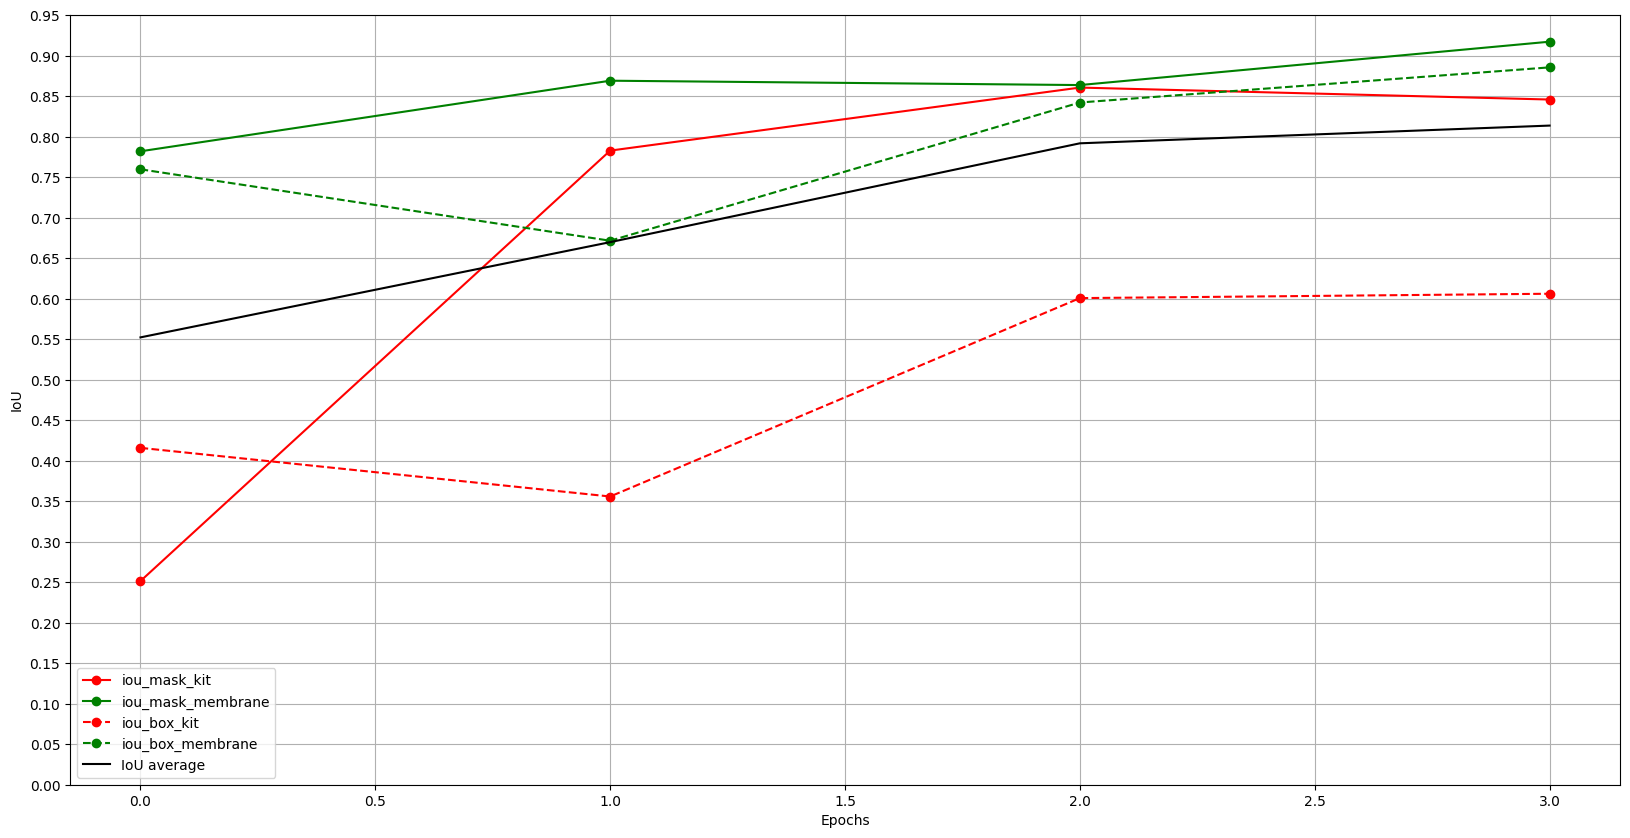

In [75]:
load_path = os.path.join(training_parameters['save_path'], '2024-02-04_17.57.38_best.state')
training_app.load_state(load_path, device='cpu')
metrics_train, metrics_val = training_app.get_metrics()
plot_metrics(metrics_val)

## Evaluating the model on test set

Once a model was trained and validated, we can check its performance on the unseen test set, stored in the folders `{kit_id}_test_images` and `{kit_id}_test_masks`. To this end, we have the `inference_segmentation` file, which contains, in particular, the function `predict_testset`. It runs inference on all images inside the test set, keeps the predictions with the best score for each image, and returns the predicted masks, and boxes for each image and class. It also returns all best scores and mask and box IoUs for each image and class in the form of a Pandas DataFrame.

In [76]:
from inference_segmentation import predict_testset

In [78]:
kit_id = 'btnx'
training_app = TrainingSegmentation(config_file=config, kit_id=kit_id)
load_path = os.path.join(training_parameters['save_path'], '2024-02-04_17.57.38_best.state')
training_app.load_state(load_path, device='cpu')
model = training_app.model
model.eval();

Using cuda device
Random seed set as 42
Loading data...
Loaded 52 image and mask paths!
Loaded 14 image and mask paths!


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MaskRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=MaskRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Using cuda device
Random seed set as 42
Loading data...
Loaded 52 image and mask paths!
Loaded 14 image and mask paths!
Loading data...
Loaded 52 image and mask paths!
Loaded 14 image and mask paths!


In [79]:
images_test, predictions_test, metrics_test, metrics_df = predict_testset(kit_id, config, model,
                                                            save_filename=None, show_bool=True)

Loaded 17 image and mask paths!


In [81]:
show_images(images_test[:4], predictions_test[:4], metrics_test[:4])

Output hidden; open in https://colab.research.google.com to view.

## References

* [Repo explaining very in detail metrics for object detection and segmentation](https://github.com/rafaelpadilla/Object-Detection-Metrics#average-precision)
* [Tutorial on how to compute performance metrics for object detection (Really good!)](https://blog.paperspace.com/mean-average-precision/)
* [Video-tutorial on how to use augmentation for segmentation](https://www.youtube.com/watch?v=rAdLwKJBvPM&t=556s)